# Ridge Regression (L2 Regularization)

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import math
from sklearn import linear_model
from sklearn.model_selection import KFold

#### Creating syntetic data

In [2]:
random.seed(98103)
n = 30

x = np.array([random.random() for i in range(n)])
x.sort()
x.shape

(30,)

In [3]:
x = x[:,np.newaxis]
x.shape

(30, 1)

In [5]:
y = np.sin(4*x)
y.shape

(30, 1)

In [6]:
e = np.array([random.gauss(0,1.0/3.0) for i in range(n)])
e=e[:,np.newaxis]
y = y+e
y.shape

(30, 1)

In [7]:
df = pd.DataFrame({"X1":x[:,0], "Y":y[:,0]})
df.head()

,X1,Y
0,0.039579,0.413238
1,0.041568,-0.119981
2,0.072432,0.553663
3,0.150289,0.753677
4,0.161334,0.431584


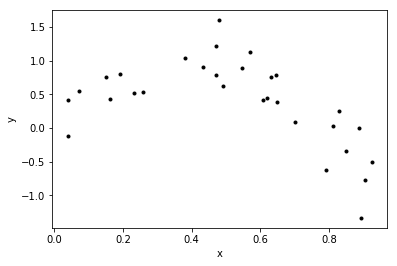

In [8]:
def plot_data(df):
    plt.plot(df["X1"], df["Y"], "k.")
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(df)

### Model

In [9]:
def polynomial_features(df, deg):
    df_copy = df.copy()
    for i in range(1, deg):
        df_copy['X'+str(i+1)] = df_copy['X'+str(i)]*df_copy["X1"]
    return df_copy

In [10]:
def polynomial_regression(df, deg, l2_alpha):
    model = linear_model.Ridge(alpha = l2_alpha)
    df = polynomial_features(df, deg)
    model = model.fit(df.drop(columns = ["Y"]), df["Y"])
    return model

In [12]:
def plot_poly_predictions(df, model):
    plot_data(df)
    
    deg = len(np.append(model.coef_, model.intercept_))-1
    
    X = pd.DataFrame({"X1": [i/200. for i in range(200)]})
    Y_pred = model.predict(polynomial_features(X, deg))
    
    plt.plot(X["X1"], Y_pred, 'g-', label = 'degree ' + str(deg) + ' fit')
    plt.legend(loc = 'upper left')
    plt.axis([0,1,-1.5,2])

In [13]:
def print_coefficients(model):
    deg = len(np.append(model.coef_, model.intercept_)) -1
    w = list(np.append(model.intercept_, model.coef_))
    print('Learned polynomial for degree' + str(deg) + ':')
    w.reverse()
    print(np.poly1d(w))

In [14]:
model = polynomial_regression(df,deg=16, l2_alpha = 100)

In [15]:
print_coefficients(model)

Learned polynomial for degree16:
           16            15           14           13           12
-0.008083 x  - 0.009025 x  - 0.01009 x  - 0.01129 x  - 0.01264 x 
            11          10           9           8           7
 - 0.01417 x  - 0.0159 x  - 0.01784 x - 0.02002 x - 0.02242 x
          6           5        4           3           2
 - 0.025 x - 0.02763 x - 0.03 x - 0.03136 x - 0.03005 x - 0.02207 x + 0.4425


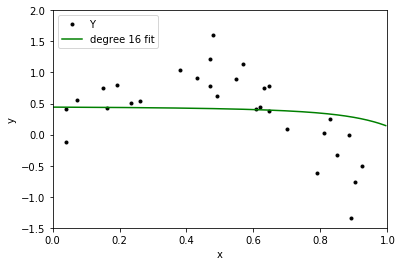

In [16]:
plot_poly_predictions(df, model)

### Fitting 16 degree polynomial using Ridge (L2) Regression for different alpha values 

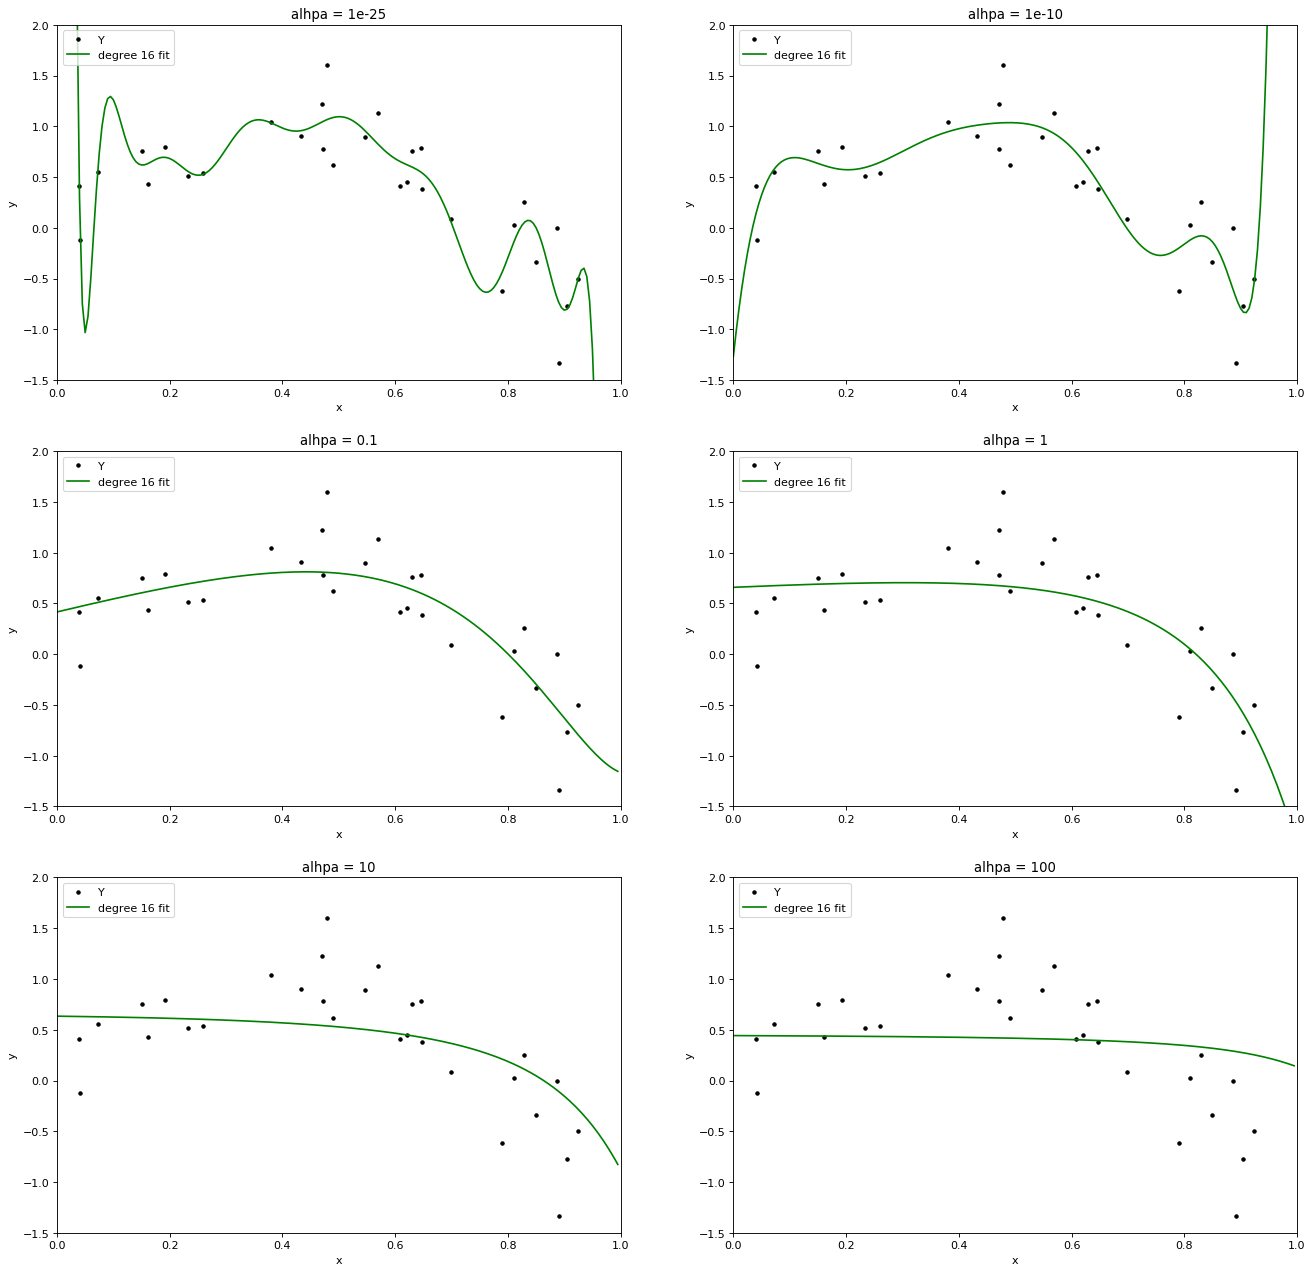

In [20]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

i=0
for alpha in [1e-25, 1e-10, 0.1, 1, 10, 100]:
    i+=1
    model = polynomial_regression(df,deg=16, l2_alpha = alpha)
    
    plt.subplot(3, 2, i)
    plot_poly_predictions(df, model)
    plt.title("alhpa = {}".format(alpha))    

### Using RidgeCV of sklearn

In [25]:
model = linear_model.RidgeCV(alphas = [1e-25, 1e-10, 0.1, 1, 10, 100], store_cv_values = True)
temp_df = polynomial_features(df, deg=16)
model = model.fit(temp_df.drop(columns = ["Y"]), temp_df["Y"])

### Function to choose the best l2 penalty using KFold

In [26]:
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    data = polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
    #folds = KFold(data,num_folds)
    
    kf = KFold(n_splits = num_folds)
    
    
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in kf.split(df):
            # train model
            train_data = data.iloc[train_set]
            val_data = data.iloc[validation_set]
            
            model = linear_model.Ridge(alpha = l2_penalty)
            model = model.fit(train_data.drop(columns = ["Y"]), train_data["Y"])
            
            
            # predict on validation set 
            y_test_predicted = model.predict(val_data.drop(columns = ['Y']))
            # compute squared error
            next_mse += ((y_test_predicted-val_data['Y'])**2).sum()
        
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse,best_l2_penalty


In [27]:
l2_penalty_values = np.logspace(-4, 10, num=10)
l2_penalty_mse,best_l2_penalty = loo(df, 16, l2_penalty_values)

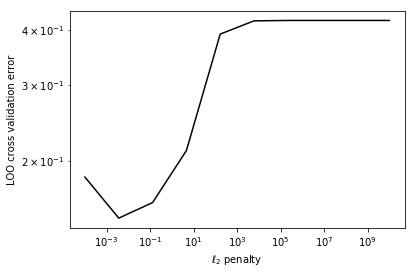

In [28]:
plt.plot(l2_penalty_values,l2_penalty_mse,'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

In [29]:
best_l2_penalty

0.003593813663804626

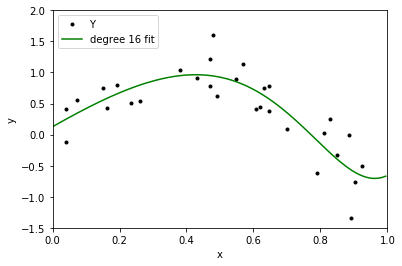

In [30]:
model = polynomial_regression(df,deg=16, l2_alpha = best_l2_penalty)

plot_poly_predictions(df,model)